Set Animal, Experiment, Treatment, and Injection Target Names

In [180]:
data_path = 'C:\\Ryan\\Imaging\\tracing\\'

exp_info = {
            'LT154': {'exp_name': '20220307_143231', 'rearing': 'NR', 'inj_site': 'LM'}}
#             'LT155': {'exp_name': '20220307_155828', 'rearing': 'NR', 'inj_site': 'LM'},
#             'LT156': {'exp_name': '20220308_110609', 'rearing': 'NR', 'inj_site': 'RL'},
#             'LT157': {'exp_name': '20220308_123041', 'rearing': 'NR', 'inj_site': 'LM'},
#             'LT158': {'exp_name': '20220308_150238', 'rearing': 'NR', 'inj_site': 'RL'},
#             'LT159': {'exp_name': '20220308_155233', 'rearing': 'NR', 'inj_site': 'AL'}}
#             'LT161': {'exp_name': '20220308_164014', 'rearing': 'NR', 'inj_site': 'AM'},
#             'LT162': {'exp_name': '20220308_134437', 'rearing': 'DR', 'inj_site': 'AL'}}
#             'LT165': {'exp_name': '20220318_115230', 'rearing': 'DR', 'inj_site': 'AL'}}
#             'LT168': {'exp_name': '20220414_102237', 'rearing': 'DR', 'inj_site': 'RL'},
#             'LT169': {'exp_name': '20220502_124437', 'rearing': 'DR', 'inj_site': 'LM'},
#             'LT170': {'exp_name': '20220502_133926', 'rearing': 'DR', 'inj_site': 'AL'},
#             'LT173': {'exp_name': '20220518_101746', 'rearing': 'NR', 'inj_site': 'AL'},
#             }

area_list = ['V1', 'LM', 'Li', 'AL', 'RL', 'AM', 'PM']

Load Data for each Animal, Process Injection Image, and Plot

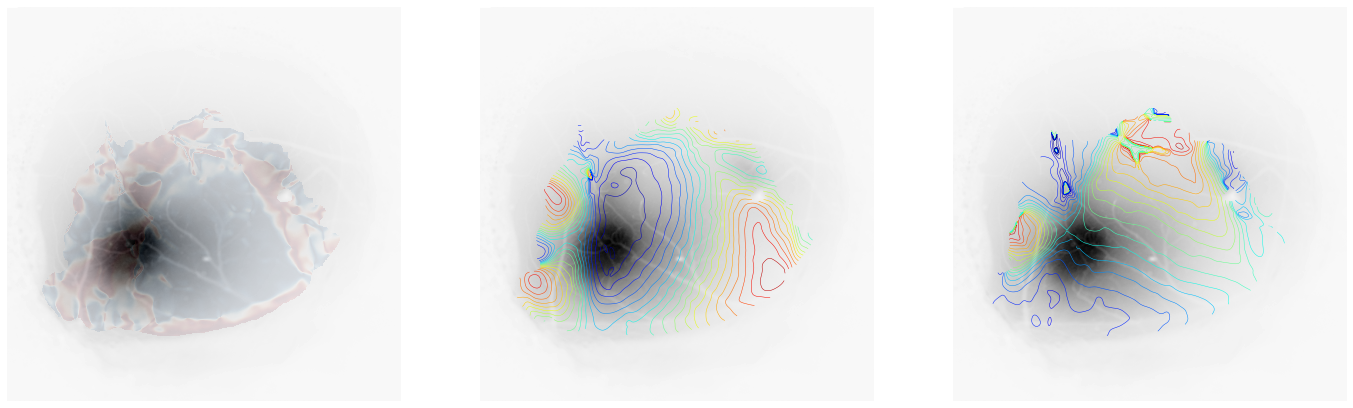

In [190]:
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
#
for exp in exp_info:
    curr_path = data_path + '{a}\\{e}\\'.format(a=exp, e=exp_info[exp]['exp_name'])
    exp_info[exp]['refframe'] = imread(curr_path + 'refframe.tif').squeeze()
    exp_info[exp]['signmap'] = np.loadtxt(curr_path + 'signmap.csv')
    exp_info[exp]['azimuth'] = np.loadtxt(curr_path + 'azimuth.csv')
    exp_info[exp]['elevation'] = np.loadtxt(curr_path + 'elevation.csv')
    injection = imread(curr_path + 'tracer.tif')
    exp_info[exp]['injection'] = 1 - (injection / np.max(injection))
    %matplotlib inline
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(exp_info[exp]['injection'], cmap='gray')
    axs[0].imshow(exp_info[exp]['signmap'], cmap='RdBu_r', clim=[-1,1], alpha=0.1)
    axs[0].axis('off')
    axs[1].imshow(exp_info[exp]['injection'], cmap='gray')
    axs[1].contour(exp_info[exp]['azimuth'], levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[1].axis('off')
    axs[2].imshow(exp_info[exp]['injection'], cmap='gray')
    axs[2].contour(exp_info[exp]['elevation'], levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[2].axis('off')
    fig.set_size_inches(24, 8)
    plt.savefig(curr_path + 'maps_injection.png')

In [207]:
def get_signmap_boundaries(signmap, dilation_factor):
    '''
    Get binary image of sign map boundaries by:
        1) Thresholding sign map around zero to detect boundary regions.
        2) Skeletonizing thresholded sign map to reduce thickness of certain boundary regions.
        3) Dilating skeletonized image by dilation_factor to make boundary thickness uniform and suitable for display purposes.
    '''
    # Detect outer edges of sign map (floats bordering nans) and set to 0
    signmap_threshold = signmap.copy()
    kernel_edge = np.array([[-1, -1, -1],
                            [-1, 1, -1],
                            [-1, -1 , -1]])
    for row in np.arange(1, signmap_threshold.shape[0] - 1):
        for col in np.arange(1, signmap_threshold.shape[1] - 1):
            curr_idx = np.ix_((row - 1, row, row + 1),(col - 1, col, col + 1))
            if not (np.isnan(signmap[row,col]) and
                        np.isnan(np.tensordot(kernel_edge, signmap_threshold[curr_idx], 
                                              axes=((0,1),(0,1))))):
                signmap_threshold[curr_idx] = 0

    # Threshold sign map around 0 to detect boundaries
    np.add.at(signmap_threshold, np.logical_or(signmap < -0.35, signmap > 0.35), np.nan)

    # Skeletonize, then dilate thresholded sign map
    from skimage.morphology import skeletonize
    signmap_skeleton = skeletonize(~np.isnan(signmap_threshold))
    kernel_dilate = np.ones((dilation_factor, dilation_factor), np.uint8)
    signmap_boundaries = cv2.dilate(signmap_skeleton.astype('float'), kernel_dilate, iterations=1)
    signmap_boundaries[signmap_boundaries == 0] = np.nan
    return signmap_boundaries

from os.path import exists
%matplotlib qt5
for exp in exp_info:
    curr_path = data_path + '{a}\\{e}\\'.format(a=exp, e=exp_info[exp]['exp_name'])
    exp_info[exp]['area_coords'] = dict(zip(area_list, [None]*len(area_list)))
    signmap_boundaries = get_signmap_boundaries(exp_info[exp]['signmap'], 3)
    for area_num,area in enumerate(area_list):
        fig, ax = plt.subplots()
        ax.imshow(exp_info[exp]['refframe'], cmap='gray')
        ax.imshow(exp_info[exp]['signmap'], cmap='RdBu_r', clim=[-1,1], alpha=0.3)
        ax.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
        if area_num > 0:
            for prev_area in area_list[:area_num]:
                ax.plot(exp_info[exp]['area_coords'][prev_area][:,0], exp_info[exp]['area_coords'][prev_area][:,1], color='k', linewidth=3)
        ax.set_title('Select Region for {ar}:'.format(ar=area), fontsize=20)
        ax.axis('off')
        fig.set_size_inches(12, 12)
        if exists(curr_path + '{ar}.csv'.format(ar=area)):
            exp_info[exp]['area_coords'][area] = np.loadtxt(curr_path + '{ar}.csv'.format(ar=area))
        else:
            curr_input = plt.ginput(n=-1, timeout=-1)
            curr_input = np.array(curr_input)
            curr_input = np.append(curr_input, [curr_input[0,:]], axis=0)
            exp_info[exp]['area_coords'][area] = curr_input
            np.savetxt(curr_path + '{ar}.csv'.format(ar=area), curr_input)
        plt.close()

Get Tracer Intensity in each Region